In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import pickle
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [3]:
# Read the metadata.csv file into a pandas DataFrame
# path = '/content/drive/My Drive/DukeStudies/548L_MLI_Project/Skin_Lesion_Classification/HAM10000data/'
path = '/content/drive/MyDrive/Sp23/BME548L_Machine_Learning_and_Imaging/548L_MLI_Project/Skin_Lesion_Classification/HAM10000data/' # Dir to full dataset
# path = '/content/drive/MyDrive/Sp23/BME548L_Machine_Learning_and_Imaging/548L_MLI_Project/Git_Repo/' # Dir to augmentated set of 1400 images with labels


#Model Training

In [4]:
# metadata = pd.read_csv(path+'train_metadata.csv')

In [5]:
# def load_and_crop(image, crop_size, normalized=True):
#     width, height = image.size   # Get dimensions
#     left = (width - crop_size)/2
#     top = (height - crop_size)/2
#     right = (width + crop_size)/2
#     bottom = (height + crop_size)/2
#     # Crop the center of the image
#     # image = ImageOps.grayscale(image.crop((left, top, right, bottom)))
#     image = image.crop((left, top, right, bottom))
#     if normalized:
#         return np.array(image).astype(np.float32) / 255.0
#     else:
#         return np.array(image).astype(np.float32)

# # Load and preprocess the images
# images = []
# labels = []

# for i, row in metadata.iterrows():
#     image = load_img(row['image_path'], target_size=(150, 200))
#     image = load_and_crop(image, 128)
#     images.append(image)
#     labels.append(row['dx'])

#     if i % 100 == 0:
#         print('Now is processing the', i+1, 'th image')
#     if i % 1000 == 0:
#         print('Progress:', i/100, '%')
#     if i >= 10000:
#         print('Progress:', i+1, '/10015')

# # Convert the images and labels to numpy arrays and adding a fake color channel
# X = np.array(images).reshape(-1, 128, 128, 3)
# print(X.shape)
# y = np.array(labels)
# print(y.shape)

# # Convert the labels to integer values
# y = pd.Series(labels).factorize()[0]

# # Convert the labels to one-hot encoded vectors
# y = to_categorical(y)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# display(X_train.shape)
# display(X_test.shape)
# display(y_train.shape)
# display(y_test.shape)

# plt.imshow(X_train[0])

In [6]:
# Load the training and test data
with open(path + 'train_data.pickle', 'rb') as f:
    train_data = pickle.load(f)

with open(path + 'test_data.pickle', 'rb') as f:
    test_data = pickle.load(f)

# Separate the images and labels
X_train = np.array([cv2.resize(item[0], (128, 128)) for item in train_data])
y_train = np.array([item[1] for item in train_data])

X_test = np.array([cv2.resize(item[0], (128, 128)) for item in test_data])
y_test = np.array([item[1] for item in test_data])

# Normalize the pixel values to range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convert string labels to integer labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Convert integer labels to one-hot encoded arrays
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Print the shape of the data
print('Training data shape:', X_train.shape)
print('Training labels shape:', y_train.shape)
print('Test data shape:', X_test.shape)
print('Test labels shape:', y_test.shape)

Training data shape: (2240, 128, 128, 3)
Training labels shape: (2240, 7)
Test data shape: (560, 128, 128, 3)
Test labels shape: (560, 7)


(-0.5, 127.5, 127.5, -0.5)

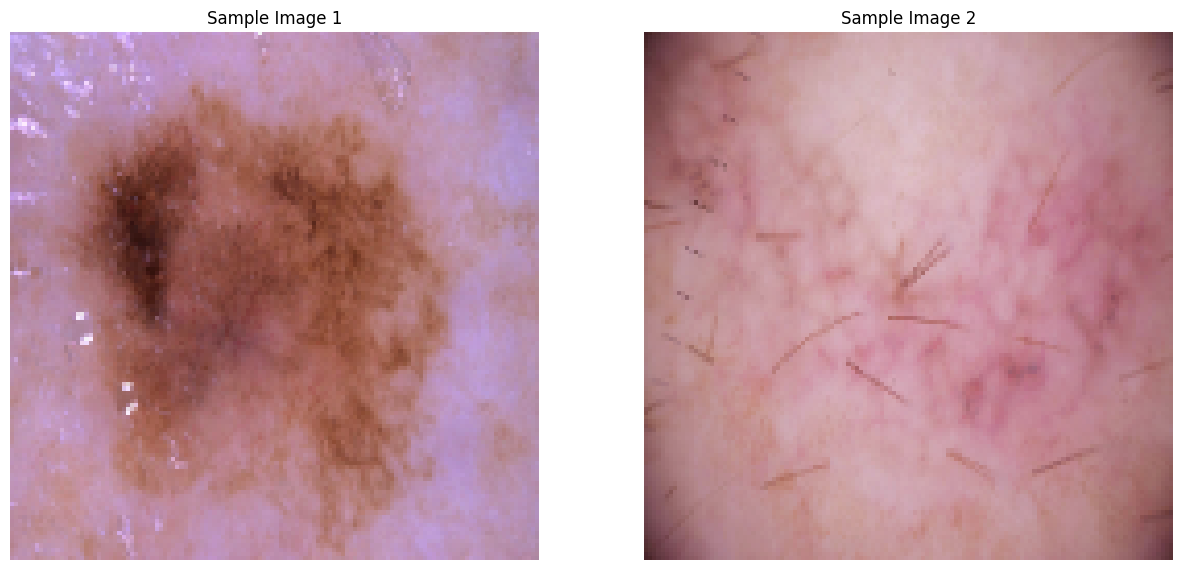

In [20]:
sample_image1 = X_train[0]
sample_image2 = X_train[1]
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(cv2.cvtColor(sample_image1, cv2.COLOR_BGR2RGB))
ax[0].set_title("Sample Image 1")
ax[0].axis('off')
ax[1].imshow(cv2.cvtColor(sample_image2, cv2.COLOR_BGR2RGB))
ax[1].set_title("Sample Image 2")
ax[1].axis('off')

In [7]:
image_size = (128, 128, 3)

# # Load the VGG16 model with imagenet weights
# vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=image_size)
# vgg16.trainable = False

base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet',pooling='avg', input_shape=image_size)

model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.Input(image_size),
    
    base_model,
    Dropout(0.5),
    Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)),
    Dropout(0.5),
    Dense(7, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02))
    
    # # convolutional layers:
    # tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides = 1, activation='relu'),
    # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides = 4, activation='relu'),
    # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 1, activation='relu'),
    # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 3, activation='relu'),

    # # dense layers:
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dense(7, activation='softmax')
])

# Compile the model with an Adam optimizer and cross-entropy loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


87910968/87910968 [==============================] - 3s 0us/step


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 22,065,959
Trainable params: 22,031,527
Non-trainable params: 34,432
_________________________________________________________________


Epoch 1/35
112/112 [==============================] - 55s 61ms/step - loss: 6.9523 - accuracy: 0.2085 - val_loss: 6.6842 - val_accuracy: 0.3000
Epoch 2/35
112/112 [==============================] - 6s 51ms/step - loss: 6.1309 - accuracy: 0.3603 - val_loss: 5.7272 - val_accuracy: 0.4696
Epoch 3/35
112/112 [==============================] - 5s 48ms/step - loss: 5.3185 - accuracy: 0.5362 - val_loss: 4.8722 - val_accuracy: 0.6554
Epoch 4/35
112/112 [==============================] - 6s 50ms/step - loss: 4.5879 - accuracy: 0.6879 - val_loss: 4.2287 - val_accuracy: 0.7339
Epoch 5/35
112/112 [==============================] - 5s 48ms/step - loss: 3.9682 - accuracy: 0.7781 - val_loss: 3.8155 - val_accuracy: 0.7607
Epoch 6/35
112/112 [==============================] - 5s 49ms/step - loss: 3.4524 - accuracy: 0.8616 - val_loss: 3.3272 - val_accuracy: 0.8429
Epoch 7/35
112/112 [==============================] - 5s 48ms/step - loss: 3.0410 - accuracy: 0.9013 - val_loss: 3.0599 - val_accuracy: 0.850

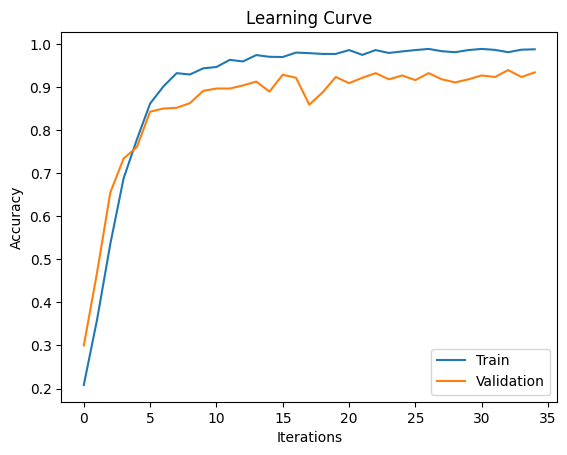

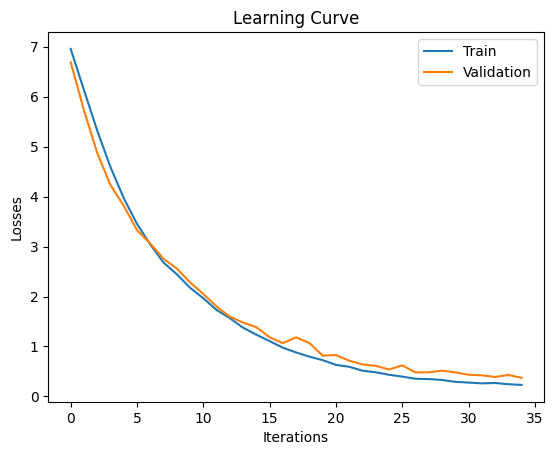

In [9]:
# Train the model on the training set
hist = model.fit(X_train, y_train, batch_size=20, epochs=35, validation_data=(X_test, y_test))

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_accuracy'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('loss'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_loss'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Losses")
plt.legend(loc='best')
plt.show()

In [10]:
# Creat Fourier Mask
def create_mask(h, w, R_factor, r_factor): 
    center = (h//2, w//2) # use the middle of the image
    s = min(h, w)
    if R_factor <= 2:
        R_factor = 2
    R = round(s/R_factor)
    if R_factor >= r_factor:
        r = 0
    else:
        r = round(s/r_factor)

    X,Y = tf.meshgrid(tf.range(h), tf.range(w))

    dist_from_center = tf.sqrt(tf.cast((X - center[0])**2 + (Y-center[1])**2, dtype=tf.float32))

    mask = np.logical_and(dist_from_center >= r, dist_from_center < R)

    return mask

In [11]:
class FourierFilter(tf.keras.layers.Layer):
    def __init__(self):
        super(FourierFilter, self).__init__()
        
    def build(self, input_shape):
        # Setting up shape parameters
        _, self.h, self.w, self.c = input_shape
        self.R_factor = 40 #@param {type:"slider", min:0, max:100, step:5}
        self.r_factor = 250 #@param {type:"slider", min:0, max:1000, step:10}
        
        # self.R_factor = self.add_weight(name='R_factor', shape=(1,), initializer='uniform', trainable=True)
        # self.r_factor = self.add_weight(name='r_factor', shape=(1,), initializer='uniform', trainable=True)
       
        # Defining the mask in the layer
        mask = create_mask(self.h, self.w, self.R_factor, self.r_factor)
        mask = tf.cast(mask, dtype=tf.complex64)
        self.mask = mask
        
    def get_mask(self):
        return self.mask
            
    def call(self, inputs):
        # Apply 2D Fourier transform to each channel
        inputs = tf.cast(inputs, dtype=tf.complex64)
        inputs = tf.transpose(inputs, perm=[0, 3, 1, 2])
        inputs_fft = tf.signal.fft2d(inputs)
        inputs_fft = tf.signal.fftshift(inputs_fft)
                
        # Apply circular mask
        inputs_fft *= self.mask
        
        # Apply 2D inverse Fourier transform
        inputs_filtered = tf.signal.ifftshift(inputs_fft)
        inputs_filtered = tf.signal.ifft2d(inputs_filtered)
        inputs_filtered = tf.cast(inputs_filtered, dtype=tf.complex64)
        inputs_filtered = tf.abs(inputs_filtered)
        inputs_filtered = tf.transpose(inputs_filtered, perm=[0,2,3,1])
        
        return inputs_filtered

In [12]:
# Create new weighted RGB image
import tensorflow.keras.backend as K

class WeightedRGBLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(WeightedRGBLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Define the trainable weights for the RGB channels
        self.r_weights = self.add_weight(name='r_weights', shape=(1,), initializer='uniform', trainable=True)
        self.g_weights = self.add_weight(name='g_weights', shape=(1,), initializer='uniform', trainable=True)
        self.b_weights = self.add_weight(name='b_weights', shape=(1,), initializer='uniform', trainable=True)

    def call(self, inputs):
        # Split the input image into its RGB channels
        r, g, b = tf.split(inputs, num_or_size_splits=3, axis=-1)

        # Scale the RGB channels by the trainable weights
        r_scaled = r * self.r_weights
        g_scaled = g * self.g_weights
        b_scaled = b * self.b_weights

        # Merge the scaled RGB channels into an image
        merged = tf.concat([r_scaled, g_scaled, b_scaled], axis=-1)
        merged = tf.cast(merged, dtype=tf.float32)

        return merged

    def compute_output_shape(self, input_shape):
        return input_shape

In [13]:
class PlotLayerOutputCallback(tf.keras.callbacks.Callback):
    def __init__(self, layer_index, img, plot_freq=5):
        super(PlotLayerOutputCallback, self).__init__()
        self.layer_index = layer_index
        self.plot_freq = plot_freq
        self.img = img
        
    def on_epoch_end(self, epoch, logs=None):
        
        # if epoch == 0:
        if (epoch+1) % self.plot_freq == 0:
            layer_output_func = tf.keras.backend.function([self.model.layers[0].input],
                                                           [self.model.layers[self.layer_index].output])
            layer_output = layer_output_func(self.img)[0] * 255
            plt.imshow(layer_output[0])
            plt.show()

plot_callback = PlotLayerOutputCallback(layer_index = 0, plot_freq = 5, img = X_train[0:2])

In [14]:
model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.Input(image_size),
    
    # RGB regenerate layer
    WeightedRGBLayer(),
    
    base_model,
    Dropout(0.5),
    Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)),
    Dropout(0.5),
    Dense(7, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02))
    
    # # convolutional layers:
    # tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides = 1, activation='relu'),
    # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides = 4, activation='relu'),
    # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 1, activation='relu'),
    # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 3, activation='relu'),

    # # dense layers:
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dense(7, activation='softmax')
])

# Compile the model with an Adam optimizer and cross-entropy loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 weighted_rgb_layer (Weighte  (None, 128, 128, 3)      3         
 dRGBLayer)                                                      
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 903       
                                                      

Epoch 1/35
112/112 [==============================] - 42s 61ms/step - loss: 6.3083 - accuracy: 0.5344 - val_loss: 6.9522 - val_accuracy: 0.1589
Epoch 2/35
112/112 [==============================] - 6s 50ms/step - loss: 5.1516 - accuracy: 0.8161 - val_loss: 9.4322 - val_accuracy: 0.1625
Epoch 3/35
112/112 [==============================] - 5s 47ms/step - loss: 4.5147 - accuracy: 0.9094 - val_loss: 7.8413 - val_accuracy: 0.2857
Epoch 4/35
112/112 [==============================] - 6s 51ms/step - loss: 4.0527 - accuracy: 0.9295 - val_loss: 5.1225 - val_accuracy: 0.5875
Epoch 5/35
112/112 [==============================] - ETA: 0s - loss: 3.6382 - accuracy: 0.9362

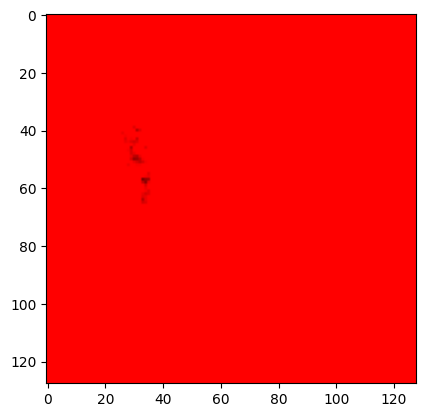

112/112 [==============================] - 6s 51ms/step - loss: 3.6382 - accuracy: 0.9362 - val_loss: 4.0542 - val_accuracy: 0.7696
Epoch 6/35
112/112 [==============================] - 6s 51ms/step - loss: 3.2267 - accuracy: 0.9549 - val_loss: 3.6628 - val_accuracy: 0.7750
Epoch 7/35
112/112 [==============================] - 5s 47ms/step - loss: 2.8731 - accuracy: 0.9585 - val_loss: 3.1258 - val_accuracy: 0.8250
Epoch 8/35
112/112 [==============================] - 6s 51ms/step - loss: 2.5444 - accuracy: 0.9576 - val_loss: 2.8218 - val_accuracy: 0.8232
Epoch 9/35
112/112 [==============================] - 6s 51ms/step - loss: 2.2628 - accuracy: 0.9589 - val_loss: 2.7269 - val_accuracy: 0.7964
Epoch 10/35
112/112 [==============================] - ETA: 0s - loss: 1.9696 - accuracy: 0.9737

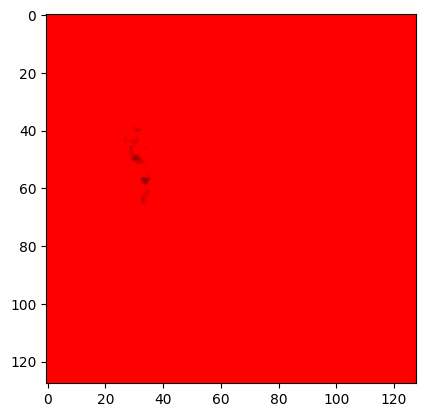

112/112 [==============================] - 6s 56ms/step - loss: 1.9696 - accuracy: 0.9737 - val_loss: 2.1982 - val_accuracy: 0.8393
Epoch 11/35
112/112 [==============================] - 6s 50ms/step - loss: 1.7367 - accuracy: 0.9732 - val_loss: 1.9809 - val_accuracy: 0.8714
Epoch 12/35
112/112 [==============================] - 6s 51ms/step - loss: 1.5022 - accuracy: 0.9799 - val_loss: 1.8342 - val_accuracy: 0.8321
Epoch 13/35
112/112 [==============================] - 6s 51ms/step - loss: 1.3363 - accuracy: 0.9786 - val_loss: 1.7112 - val_accuracy: 0.8464
Epoch 14/35
112/112 [==============================] - 6s 51ms/step - loss: 1.1849 - accuracy: 0.9732 - val_loss: 1.5257 - val_accuracy: 0.8339
Epoch 15/35
111/112 [============================>.] - ETA: 0s - loss: 1.0142 - accuracy: 0.9842

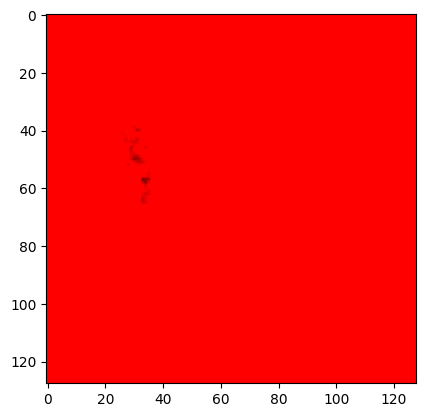

112/112 [==============================] - 6s 53ms/step - loss: 1.0155 - accuracy: 0.9839 - val_loss: 1.4285 - val_accuracy: 0.8464
Epoch 16/35
112/112 [==============================] - 6s 51ms/step - loss: 0.9128 - accuracy: 0.9790 - val_loss: 1.2988 - val_accuracy: 0.8268
Epoch 17/35
112/112 [==============================] - 6s 51ms/step - loss: 0.7828 - accuracy: 0.9848 - val_loss: 1.1054 - val_accuracy: 0.8750
Epoch 18/35
112/112 [==============================] - 5s 48ms/step - loss: 0.6994 - accuracy: 0.9839 - val_loss: 1.2630 - val_accuracy: 0.7964
Epoch 19/35
112/112 [==============================] - 6s 51ms/step - loss: 0.6271 - accuracy: 0.9808 - val_loss: 1.1358 - val_accuracy: 0.8214
Epoch 20/35
111/112 [============================>.] - ETA: 0s - loss: 0.5493 - accuracy: 0.9847

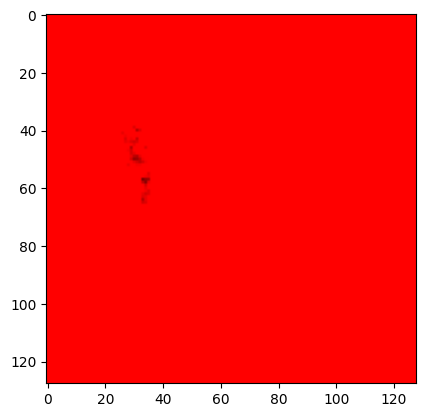

112/112 [==============================] - 6s 50ms/step - loss: 0.5489 - accuracy: 0.9848 - val_loss: 1.1162 - val_accuracy: 0.8143
Epoch 21/35
112/112 [==============================] - 6s 52ms/step - loss: 0.4779 - accuracy: 0.9893 - val_loss: 0.8264 - val_accuracy: 0.8625
Epoch 22/35
112/112 [==============================] - 5s 48ms/step - loss: 0.4270 - accuracy: 0.9906 - val_loss: 0.8287 - val_accuracy: 0.8500
Epoch 23/35
112/112 [==============================] - 6s 51ms/step - loss: 0.3842 - accuracy: 0.9906 - val_loss: 0.6894 - val_accuracy: 0.8893
Epoch 24/35
112/112 [==============================] - 5s 48ms/step - loss: 0.3472 - accuracy: 0.9924 - val_loss: 0.7444 - val_accuracy: 0.8536
Epoch 25/35
112/112 [==============================] - ETA: 0s - loss: 0.3427 - accuracy: 0.9826

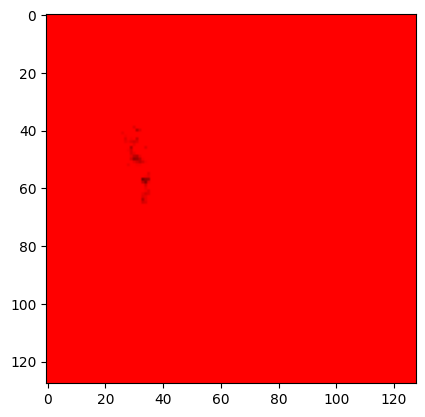

112/112 [==============================] - 6s 53ms/step - loss: 0.3427 - accuracy: 0.9826 - val_loss: 1.4911 - val_accuracy: 0.6661
Epoch 26/35
112/112 [==============================] - 5s 47ms/step - loss: 0.3104 - accuracy: 0.9844 - val_loss: 0.9029 - val_accuracy: 0.7786
Epoch 27/35
112/112 [==============================] - 6s 50ms/step - loss: 0.2726 - accuracy: 0.9920 - val_loss: 0.6019 - val_accuracy: 0.8875
Epoch 28/35
112/112 [==============================] - 5s 48ms/step - loss: 0.2580 - accuracy: 0.9902 - val_loss: 0.8640 - val_accuracy: 0.8250
Epoch 29/35
112/112 [==============================] - 5s 48ms/step - loss: 0.2507 - accuracy: 0.9857 - val_loss: 0.6194 - val_accuracy: 0.8732
Epoch 30/35
112/112 [==============================] - ETA: 0s - loss: 0.2361 - accuracy: 0.9902

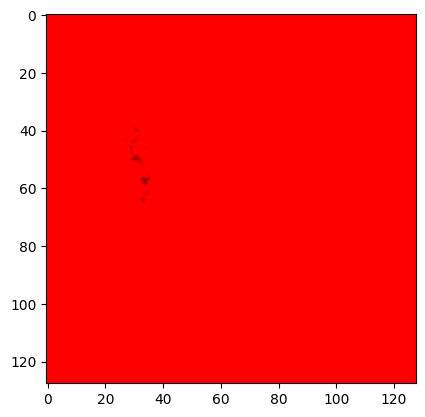

112/112 [==============================] - 6s 52ms/step - loss: 0.2361 - accuracy: 0.9902 - val_loss: 0.6797 - val_accuracy: 0.8375
Epoch 31/35
112/112 [==============================] - 5s 48ms/step - loss: 0.2219 - accuracy: 0.9884 - val_loss: 1.0761 - val_accuracy: 0.7321
Epoch 32/35
112/112 [==============================] - 6s 50ms/step - loss: 0.2152 - accuracy: 0.9902 - val_loss: 0.7905 - val_accuracy: 0.8125
Epoch 33/35
112/112 [==============================] - 5s 48ms/step - loss: 0.2183 - accuracy: 0.9853 - val_loss: 0.7055 - val_accuracy: 0.8339
Epoch 34/35
112/112 [==============================] - 6s 50ms/step - loss: 0.2016 - accuracy: 0.9884 - val_loss: 0.5373 - val_accuracy: 0.8786
Epoch 35/35
112/112 [==============================] - ETA: 0s - loss: 0.2091 - accuracy: 0.9857

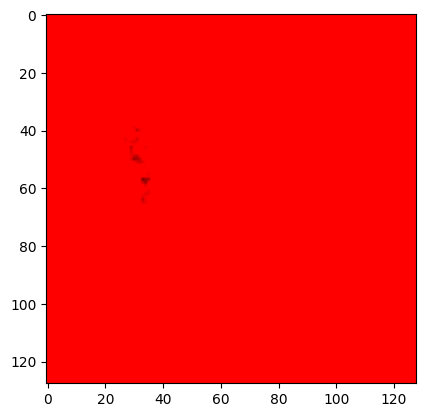

112/112 [==============================] - 6s 50ms/step - loss: 0.2091 - accuracy: 0.9857 - val_loss: 0.8610 - val_accuracy: 0.7875


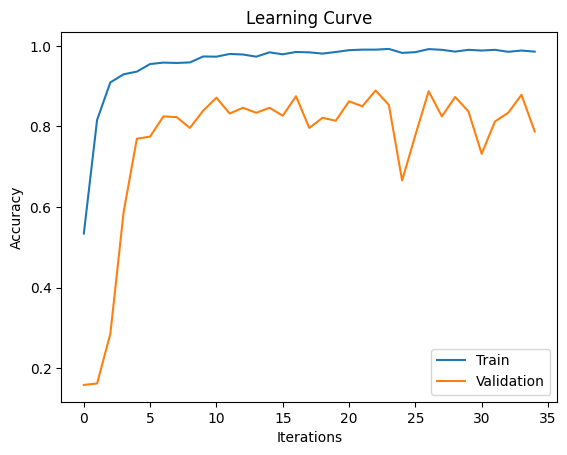

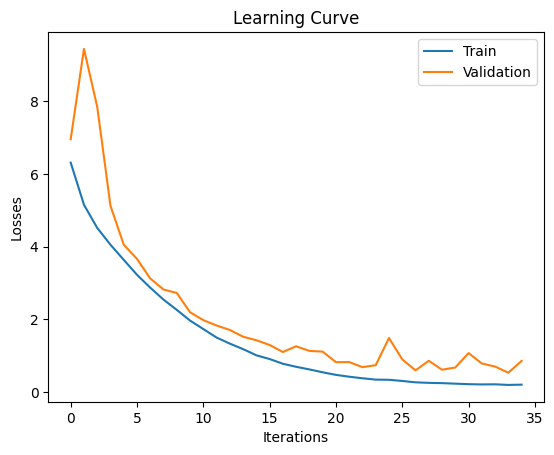

In [16]:
# Train model with callback
hist = model.fit(X_train, y_train, batch_size=20, epochs=35, validation_data=(X_test, y_test), callbacks=[plot_callback])

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_accuracy'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('loss'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_loss'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Losses")
plt.legend(loc='best')
plt.show()

Epoch 1/35
112/112 [==============================] - 42s 64ms/step - loss: 6.9676 - accuracy: 0.2705 - val_loss: 6.5598 - val_accuracy: 0.2982
Epoch 2/35
112/112 [==============================] - 6s 49ms/step - loss: 6.1325 - accuracy: 0.4451 - val_loss: 5.8185 - val_accuracy: 0.5179
Epoch 3/35
112/112 [==============================] - 6s 50ms/step - loss: 5.6006 - accuracy: 0.5433 - val_loss: 5.4282 - val_accuracy: 0.5393
Epoch 4/35
112/112 [==============================] - 5s 48ms/step - loss: 5.0133 - accuracy: 0.6496 - val_loss: 5.1441 - val_accuracy: 0.5375
Epoch 5/35
112/112 [==============================] - 6s 50ms/step - loss: 4.4476 - accuracy: 0.7433 - val_loss: 4.7988 - val_accuracy: 0.5893
Epoch 6/35
112/112 [==============================] - 5s 48ms/step - loss: 3.9986 - accuracy: 0.8196 - val_loss: 4.4201 - val_accuracy: 0.6304
Epoch 7/35
112/112 [==============================] - 6s 52ms/step - loss: 3.5293 - accuracy: 0.8790 - val_loss: 4.3299 - val_accuracy: 0.601

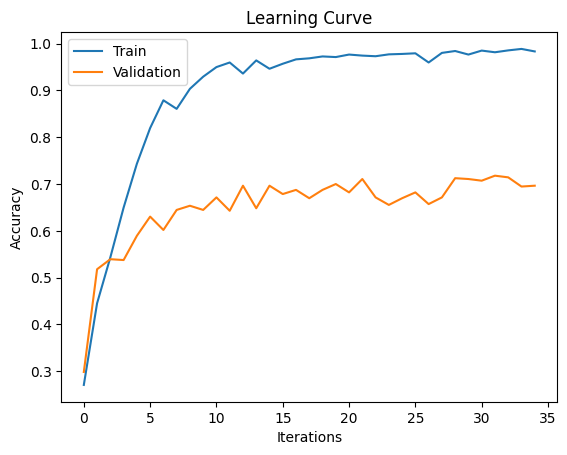

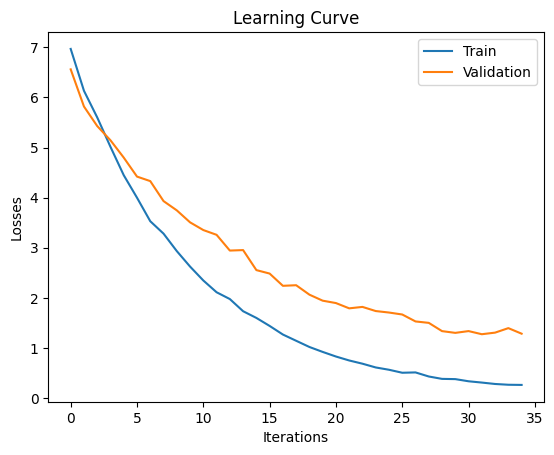

In [17]:
model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.Input(image_size),
    
    # FFT layer
    FourierFilter(),
    
    base_model,
    Dropout(0.5),
    Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)),
    Dropout(0.5),
    Dense(7, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02))
    
    # # convolutional layers:
    # tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides = 1, activation='relu'),
    # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides = 4, activation='relu'),
    # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 1, activation='relu'),
    # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 3, activation='relu'),

    # # dense layers:
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dense(7, activation='softmax')
])

# Compile the model with an Adam optimizer and cross-entropy loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model with callback
hist = model.fit(X_train, y_train, batch_size=20, epochs=35, validation_data=(X_test, y_test))

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_accuracy'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('loss'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_loss'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Losses")
plt.legend(loc='best')
plt.show()

Epoch 1/35


112/112 [==============================] - 43s 66ms/step - loss: 5.8975 - accuracy: 0.6723 - val_loss: 9.7251 - val_accuracy: 0.1268
Epoch 2/35
112/112 [==============================] - 6s 54ms/step - loss: 4.7645 - accuracy: 0.9330 - val_loss: 8.7685 - val_accuracy: 0.2161
Epoch 3/35
112/112 [==============================] - 6s 53ms/step - loss: 4.2262 - accuracy: 0.9643 - val_loss: 6.8490 - val_accuracy: 0.4107
Epoch 4/35
112/112 [==============================] - 6s 53ms/step - loss: 3.7690 - accuracy: 0.9696 - val_loss: 5.4460 - val_accuracy: 0.5411
Epoch 5/35
112/112 [==============================] - ETA: 0s - loss: 3.3423 - accuracy: 0.9674

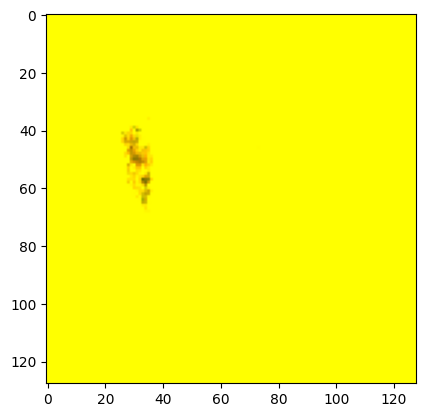

112/112 [==============================] - 6s 52ms/step - loss: 3.3423 - accuracy: 0.9674 - val_loss: 4.6090 - val_accuracy: 0.6107
Epoch 6/35
112/112 [==============================] - 6s 53ms/step - loss: 2.9038 - accuracy: 0.9790 - val_loss: 4.0723 - val_accuracy: 0.6607
Epoch 7/35
112/112 [==============================] - 6s 51ms/step - loss: 2.5255 - accuracy: 0.9772 - val_loss: 3.5009 - val_accuracy: 0.6982
Epoch 8/35
112/112 [==============================] - 6s 53ms/step - loss: 2.2455 - accuracy: 0.9625 - val_loss: 3.6262 - val_accuracy: 0.5411
Epoch 9/35
112/112 [==============================] - 6s 50ms/step - loss: 1.9340 - accuracy: 0.9714 - val_loss: 2.7267 - val_accuracy: 0.6964
Epoch 10/35
112/112 [==============================] - ETA: 0s - loss: 1.6381 - accuracy: 0.9759

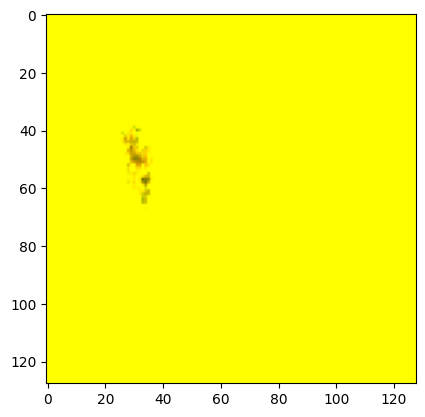

112/112 [==============================] - 6s 53ms/step - loss: 1.6381 - accuracy: 0.9759 - val_loss: 2.8088 - val_accuracy: 0.6750
Epoch 11/35
112/112 [==============================] - 6s 50ms/step - loss: 1.4203 - accuracy: 0.9835 - val_loss: 2.4141 - val_accuracy: 0.6768
Epoch 12/35
112/112 [==============================] - 6s 49ms/step - loss: 1.2002 - accuracy: 0.9884 - val_loss: 2.1258 - val_accuracy: 0.7268
Epoch 13/35
112/112 [==============================] - 6s 51ms/step - loss: 1.0389 - accuracy: 0.9871 - val_loss: 2.0065 - val_accuracy: 0.7071
Epoch 14/35
112/112 [==============================] - 6s 49ms/step - loss: 0.9257 - accuracy: 0.9759 - val_loss: 2.0189 - val_accuracy: 0.6839
Epoch 15/35
112/112 [==============================] - ETA: 0s - loss: 0.7887 - accuracy: 0.9839

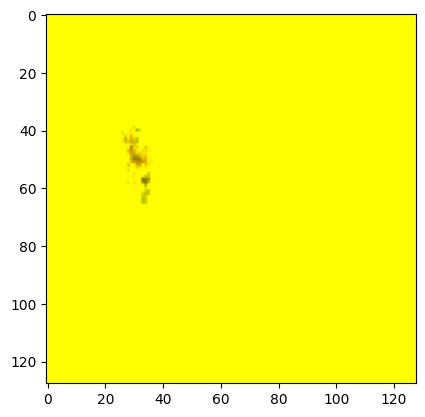

112/112 [==============================] - 6s 53ms/step - loss: 0.7887 - accuracy: 0.9839 - val_loss: 1.7898 - val_accuracy: 0.7000
Epoch 16/35
112/112 [==============================] - 6s 50ms/step - loss: 0.6573 - accuracy: 0.9920 - val_loss: 1.8759 - val_accuracy: 0.6518
Epoch 17/35
112/112 [==============================] - 6s 52ms/step - loss: 0.5823 - accuracy: 0.9862 - val_loss: 1.5603 - val_accuracy: 0.7196
Epoch 18/35
112/112 [==============================] - 6s 50ms/step - loss: 0.5188 - accuracy: 0.9857 - val_loss: 1.9811 - val_accuracy: 0.6125
Epoch 19/35
112/112 [==============================] - 6s 52ms/step - loss: 0.4630 - accuracy: 0.9875 - val_loss: 1.3310 - val_accuracy: 0.7464
Epoch 20/35
112/112 [==============================] - ETA: 0s - loss: 0.4180 - accuracy: 0.9826

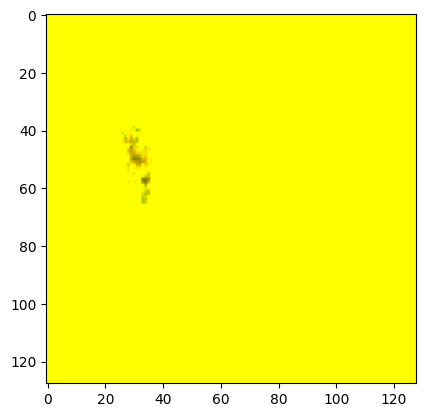

112/112 [==============================] - 6s 51ms/step - loss: 0.4180 - accuracy: 0.9826 - val_loss: 1.4394 - val_accuracy: 0.7286
Epoch 21/35
112/112 [==============================] - 6s 52ms/step - loss: 0.3718 - accuracy: 0.9857 - val_loss: 1.3851 - val_accuracy: 0.6964
Epoch 22/35
112/112 [==============================] - 6s 49ms/step - loss: 0.3344 - accuracy: 0.9875 - val_loss: 1.2491 - val_accuracy: 0.7250
Epoch 23/35
112/112 [==============================] - 6s 52ms/step - loss: 0.3123 - accuracy: 0.9862 - val_loss: 1.2357 - val_accuracy: 0.7554
Epoch 24/35
112/112 [==============================] - 6s 50ms/step - loss: 0.2769 - accuracy: 0.9879 - val_loss: 1.2356 - val_accuracy: 0.7411
Epoch 25/35
112/112 [==============================] - ETA: 0s - loss: 0.2619 - accuracy: 0.9884

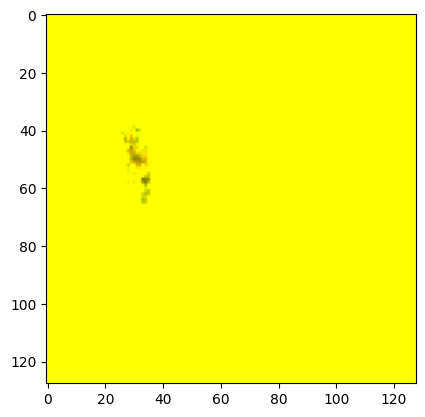

112/112 [==============================] - 6s 54ms/step - loss: 0.2619 - accuracy: 0.9884 - val_loss: 1.1911 - val_accuracy: 0.7214
Epoch 26/35
112/112 [==============================] - 5s 49ms/step - loss: 0.2434 - accuracy: 0.9897 - val_loss: 1.2313 - val_accuracy: 0.7071
Epoch 27/35
112/112 [==============================] - 6s 50ms/step - loss: 0.2520 - accuracy: 0.9826 - val_loss: 1.3298 - val_accuracy: 0.6893
Epoch 28/35
112/112 [==============================] - 6s 49ms/step - loss: 0.2042 - accuracy: 0.9942 - val_loss: 1.0614 - val_accuracy: 0.7482
Epoch 29/35
112/112 [==============================] - 6s 49ms/step - loss: 0.2063 - accuracy: 0.9893 - val_loss: 1.6724 - val_accuracy: 0.6286
Epoch 30/35
111/112 [============================>.] - ETA: 0s - loss: 0.2086 - accuracy: 0.9869

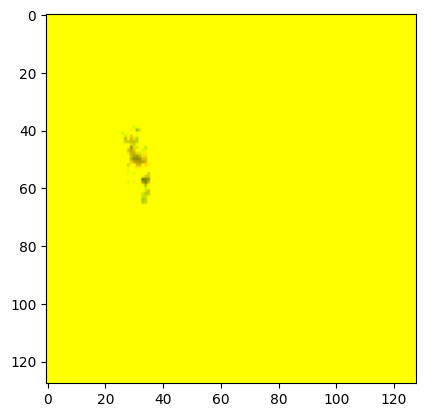

112/112 [==============================] - 6s 54ms/step - loss: 0.2083 - accuracy: 0.9871 - val_loss: 1.2184 - val_accuracy: 0.7107
Epoch 31/35
112/112 [==============================] - 6s 50ms/step - loss: 0.2139 - accuracy: 0.9853 - val_loss: 1.2898 - val_accuracy: 0.6893
Epoch 32/35
112/112 [==============================] - 6s 51ms/step - loss: 0.1924 - accuracy: 0.9884 - val_loss: 1.1108 - val_accuracy: 0.7268
Epoch 33/35
112/112 [==============================] - 5s 49ms/step - loss: 0.1907 - accuracy: 0.9862 - val_loss: 1.1817 - val_accuracy: 0.7125
Epoch 34/35
112/112 [==============================] - 6s 52ms/step - loss: 0.1803 - accuracy: 0.9875 - val_loss: 1.2005 - val_accuracy: 0.7000
Epoch 35/35
111/112 [============================>.] - ETA: 0s - loss: 0.2073 - accuracy: 0.9842

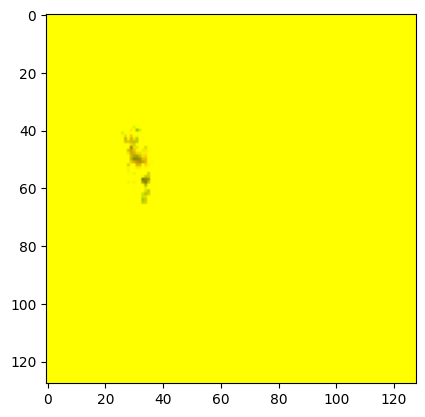

112/112 [==============================] - 6s 51ms/step - loss: 0.2068 - accuracy: 0.9844 - val_loss: 1.2548 - val_accuracy: 0.6929


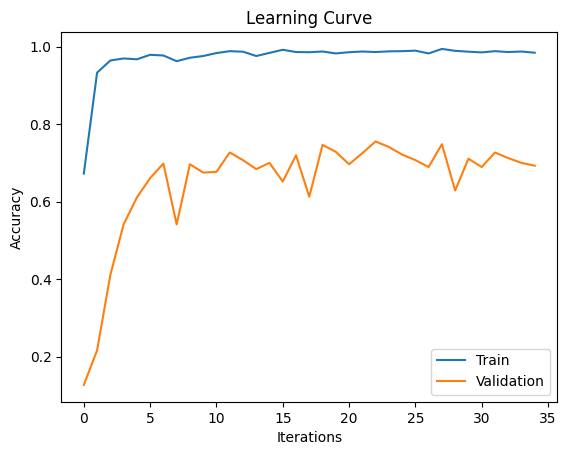

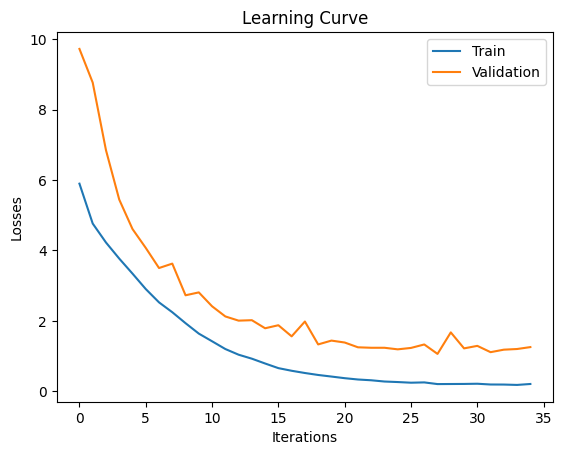

In [18]:
model = tf.keras.models.Sequential([
    # Input layer
    tf.keras.layers.Input(image_size),
    
    # RGB regenerate layer
    WeightedRGBLayer(),

    # FFT layer
    FourierFilter(),

    base_model,
    Dropout(0.5),
    Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)),
    Dropout(0.5),
    Dense(7, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02))
    
    # # convolutional layers:
    # tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides = 1, activation='relu'),
    # tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides = 4, activation='relu'),
    # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 1, activation='relu'),
    # tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides = 3, activation='relu'),

    # # dense layers:
    # tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dense(7, activation='softmax')
])

# Compile the model with an Adam optimizer and cross-entropy loss function
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train model with callback
hist = model.fit(X_train, y_train, batch_size=20, epochs=35, validation_data=(X_test, y_test), callbacks=[plot_callback])

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('accuracy'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_accuracy'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

plt.title("Learning Curve")
plt.plot(np.arange(35),hist.history.get('loss'), label="Train")
plt.plot(np.arange(35),hist.history.get('val_loss'), label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Losses")
plt.legend(loc='best')
plt.show()